# Estival/PyMC

In this notebook, we will build a BayesianCompartmentalModel, and calibrate it using PyMC

In [1]:
#conda create -n emulearn python=3.10

In [2]:
#pip install summerepi2 estival jax==0.4.24 jaxlib==0.4.24 nevergrad jupyter pymc numpyro

In [3]:
#pip show estival

In [4]:
#conda install m2w64-toolchain

In [5]:
# Uncomment the following to install in colab
# Note that you need to restart your colab environment after installing - just click the 'Restart' button

#!pip uninstall numba -y
#!pip uninstall librosa -y
#!pip install estival==0.4.4 numpy==1.24.3
#pip install pflacco #The package for ELA
#pip install mkl #For optimized execution

In [2]:
# This is required for pymc parallel evaluation in notebooks

import multiprocess as mp
import platform

if platform.system() != "Windows":
    
    mp.set_start_method('forkserver')

In [3]:
import summer2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

In [4]:
from summer2.extras import test_models

In [5]:
start = time()

m = test_models.sir()
end = time()

print("Elapsed time ", end - start)
#m?
#m.request_output_for_flow?

Elapsed time  0.003180980682373047


<Axes: >

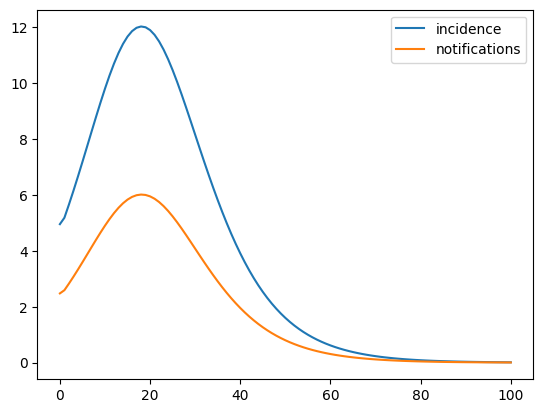

In [6]:
m.run({'contact_rate': 0.5, 'recovery_rate': 0.4, 'cdr': 0.5} )
m.get_derived_outputs_df().plot()

In [7]:
defp = m.get_default_parameters()
print("Default parameters : ", defp, "\n")

Default parameters :  {'contact_rate': 0.4, 'recovery_rate': 0.1, 'cdr': 0.2} 



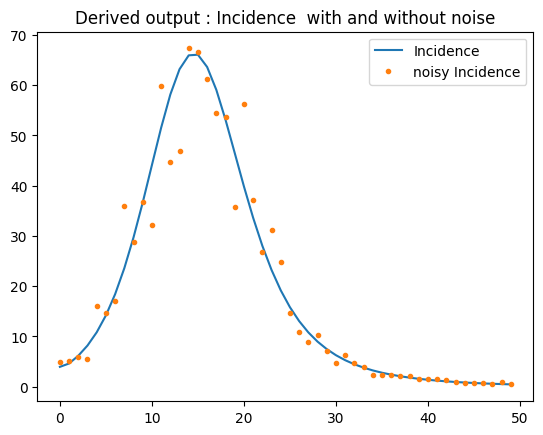

In [8]:
m.run({"contact_rate": 0.4, "recovery_rate": 0.1})
do_def = m.get_derived_outputs_df()
obs_clean = do_def["incidence"].iloc[0:50]
obs_noisy = obs_clean * np.exp(np.random.normal(0.0,0.2,len(obs_clean))) # A expliquer !!
obs_clean.plot(label = 'Incidence')
obs_noisy.plot(label = 'noisy Incidence', style='.')
plt.title('Derived output : Incidence  with and without noise')
plt.legend(loc = 'best')

In [9]:
"""
m.run({"contact_rate": 0.5, "recovery_rate": 0.5})
do_def_2 = m.get_derived_outputs_df()
obs_clean_2 = do_def_2["incidence"].iloc[0:50]

obs_clean_2.plot()
"""

'\nm.run({"contact_rate": 0.5, "recovery_rate": 0.5})\ndo_def_2 = m.get_derived_outputs_df()\nobs_clean_2 = do_def_2["incidence"].iloc[0:50]\n\nobs_clean_2.plot()\n'

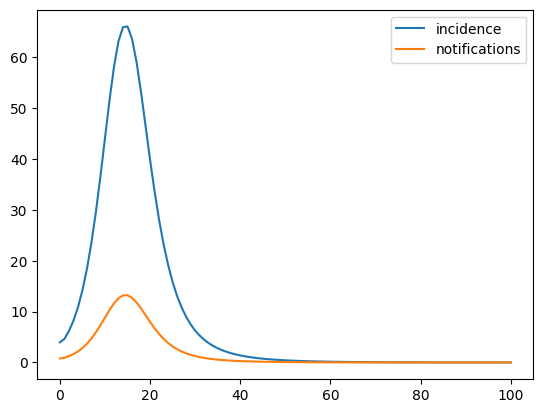

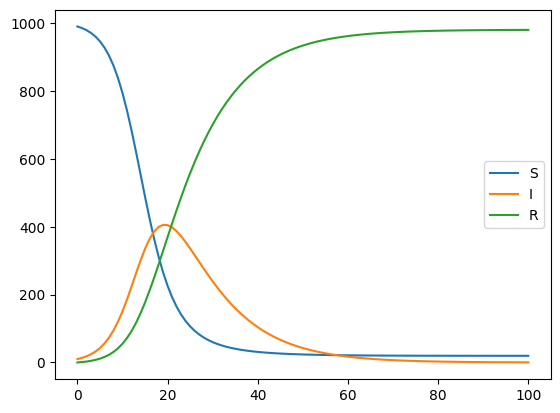

In [10]:
do_def.plot()
m.get_outputs_df().plot();

In [11]:
# The following imports are the 'building blocks' of estival models

# Targets represent data we are trying to fit to
from estival import targets as est
import estival
# We specify parameters using (Bayesian) priors
from estival import priors as esp

# Finally we combine these with our summer2 model in a BayesianCompartmentalModel (BCM)
import estival.model
from estival.model import BayesianCompartmentalModel

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [12]:
#print(np.__config__.show())

In [13]:
# Specify a Truncated normal target with a free dispersion parameter
targets = [
    est.TruncatedNormalTarget("incidence", obs_noisy, (0.0,np.inf),
        #esp.UniformPrior("incidence_dispersion",(0.1, obs_noisy.max()*0.1))) #Calibration de l'ecart type
        3) #Utiliser un nombre fixe pour ne pas l'inclure dans la calibration
                            
]

In [14]:
# Uniform priors over our 2 model parameters
priors = [
    esp.UniformPrior("contact_rate", (0.01,1.0)),
    esp.TruncNormalPrior("recovery_rate", 0.5, 0.2, (0.01,1.0)),
]


In [15]:
# The BayesianCompartmentalModel class is the primary entry point to all optimization and calibration
# methods in estival
# It takes a CompartmentalModel object, default parameters, priors, and targets
# The default parameters will be used as fixed values when no prior is specified for a given parameter

#______Runing the model with the default parameters ________
bcm_defp = estival.model.BayesianCompartmentalModel(m, defp, priors, targets)
bcm_defp.run(defp, include_extras=True).extras['logposterior']

Array(-4.70986461, dtype=float64)

## Exploiting the posterior likelihood for ELA studies
Don't forget that ELA features are basicly disigned for minimization problem instead here the Logposterior is to be maximized soon

In [16]:
#____We generate a sample of parameters which will allow us to study the landscape of our logposterior
#____Using Latin Hypercube Sampling to do so

#!pip install pflacco #Installing the pflacco package for Landscape Analysis
#---------Some features---------------
from pflacco.classical_ela_features import *
from pflacco.classical_ela_features import calculate_ela_distribution
from pflacco.misc_features import calculate_fitness_distance_correlation
from pflacco.local_optima_network_features import compute_local_optima_network, calculate_lon_features

#__To___create_a_initial____sample
from pflacco.sampling import create_initial_sample

In [ ]:
pip install pflacco


In [ ]:
create_initial_sample?

### Sampling


In [17]:
dim = 2 #Number of parameters
N = 2**np.arange(2,12)#40*dim #Fixed number of sample to create, typically scaled to dim 
# Create inital sample using latin hyper cube sampling/Sobol
def compute_distr(n):
    import estival
    from summer2.extras import test_models
    m = test_models.sir()
    defp = m.get_default_parameters()
    from pflacco.sampling import create_initial_sample
    bcm = estival.model.BayesianCompartmentalModel(m, defp, priors, targets)

    dim = 2 #Number of parameters
    def Logposterior(x):
        params = {'contact_rate': x[0], 'recovery_rate': x[1], 'cdr': 0.2}
        #bcm = BayesianCompartmentalModel(m, params, priors, targets)
        bcm.run(params)
        return float(bcm.logposterior(**params))
    
    # Create inital sample using latin hyper cube sampling
    X = create_initial_sample(dim, n, sample_type = 'sobol')
    
    Y = X.apply(lambda x:  Logposterior(x), axis=1)
    mask = Y == -np.inf    
        #Replacing the -inf values by a real value
    Y[mask] = -10e60
    return calculate_ela_distribution(X,Y)

#X = create_initial_sample(dim, N, sample_type = 'sobol')
#X = -X
#X1 = create_initial_sample(dim, N, sample_type = 'lhs') #Another sample

#x0 --> contact_rate; 
#x1 --> recovery_rate
#print("Sample 1 : ", X,"\n ___________________________________ ")
#print("Sample 2 : ", X1,"\n ___________________________________ ")


#X.index = np.arange(0,100,1)


array([   4,    8,   16,   32,   64,  128,  256,  512, 1024, 2048],
      dtype=int32)

### Runing the model on samples

In [18]:
#Evaluate the logposterior function using these sampled parameters
from concurrent.futures import ThreadPoolExecutor
defp = {'contact_rate': 0.4, 'recovery_rate': 0.1, 'cdr': 0.2}
bcm = BayesianCompartmentalModel(m, defp, priors, targets)

def Logposterior(x):
    params = {'contact_rate': x[0], 'recovery_rate': x[1], 'cdr': 0.2}
    #bcm = BayesianCompartmentalModel(m, params, priors, targets)
    bcm.run(params)
    return float(bcm.logposterior(**params))

def negative(f, *args, **kwargs):
    """Wrap a positive function such that a minimizable version is returned instead

    Args:
        f: The callable to wrap
    """

    def _reflected(*args, **kwargs):
        return float(0.0 - f(*args, **kwargs))

    return _reflected

def objective_func(x):
    return float(Logposterior(x))

In [57]:

bcm.run(defp)

print(bcm.logposterior(**defp))

print("From extra",  bcm.run(defp, include_extras=True).extras['logposterior'])


-4.7098646145320435
From extra -4.7098646145320435


In [251]:
# Use ThreadPoolExecutor to parallelize iteration(In the case of differents sample size)
#Y = np.array(N) # Will contain the logposterior values
N = 2**np.arange(2,10)#40*dim #Fixed number of sample to create, typically scaled to dim 
Logposterior = negative(Logposterior)
#with mp.Pool() as pool:
for n in N:
    #Compute an examplary feature set from the convential ELA features of the R-package flacco
# n = 2**5

    start = time.time()
    X = create_initial_sample(dim, n, sample_type = 'sobol')
    
    Y = X.apply(lambda x:  float(Logposterior(x)), axis=1)
    mask = Y == -np.inf    
    #Replacing the -inf values by a real value
    Y[mask] = -10e60
    ela_distr = calculate_ela_distribution(X,Y)
    end = time.time()
    print("Sample size n =  ",n," \n", ela_distr,"\n_________________________________________________________")
    
    print("Elapsed time in seconde : ", end-start)
pass
"""
with ThreadPoolExecutor() as executor:
    # Use zip to iterate over both data lists simultaneously
    for index, (x0, x1, x01, x11) in enumerate(zip(X['x0'], X['x1'],X1['x0'], X1['x1'])):
        y = executor.submit(Logposterior, x0, x1)
        #y1 = executor.submit(Logposterior, x01, x11)

        #print(index)
        #print(y.result())
        Y[index] = y.result()
        #Y1[index] = y1.result()
"""
pass    
"""
for x0, x1 in zip(X['x0'], X['x1']):

    params = {'contact_rate': x0, 'recovery_rate': x1, 'cdr': 0.2}
    #print(params)
    bcm = BayesianCompartmentalModel(m, params, priors, targets)
    y = bcm.run(params, include_extras=True).extras['logposterior']
    #print('y = ', y)
    y = Logpsterior
    Y.append(y)
"""
#Y = np.asarray(Y)
#Y = np.concatenate(Y).astype(None)
#print(Y)

Sample size n =   4  
 {'ela_distr.skewness': 0.024457292907702606, 'ela_distr.kurtosis': -2.3861612305390922, 'ela_distr.number_of_peaks': 2, 'ela_distr.costs_runtime': 0.0} 
_________________________________________________________
Elapsed time in seconde :  0.014650583267211914
Sample size n =   8  
 {'ela_distr.skewness': 0.4187282122822921, 'ela_distr.kurtosis': -1.9724123997104224, 'ela_distr.number_of_peaks': 2, 'ela_distr.costs_runtime': 0.0} 
_________________________________________________________
Elapsed time in seconde :  0.0175783634185791
Sample size n =   16  
 {'ela_distr.skewness': -1.689135168978304, 'ela_distr.kurtosis': 3.634296390466674, 'ela_distr.number_of_peaks': 2, 'ela_distr.costs_runtime': 0.0} 
_________________________________________________________
Elapsed time in seconde :  0.026746749877929688
Sample size n =   32  
 {'ela_distr.skewness': -1.8624973822413253, 'ela_distr.kurtosis': 4.55514310265794, 'ela_distr.number_of_peaks': 2, 'ela_distr.costs_runt

"\nfor x0, x1 in zip(X['x0'], X['x1']):\n\n    params = {'contact_rate': x0, 'recovery_rate': x1, 'cdr': 0.2}\n    #print(params)\n    bcm = BayesianCompartmentalModel(m, params, priors, targets)\n    y = bcm.run(params, include_extras=True).extras['logposterior']\n    #print('y = ', y)\n    y = Logpsterior\n    Y.append(y)\n"

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
n = 2**12
X = create_initial_sample(dim, n, sample_type = 'sobol')
Logposterior = negative(Logposterior)
Y = X.apply(lambda x:  float(Logposterior(x.values)), axis=1)
mask = Y == -np.inf    
#Replacing the -inf values by a real value
#Y[mask] = -10e60

xx = X['x0']
yy = X['x1']
def Logposterior2(x,y):
   params = {'contact_rate': x, 'recovery_rate': y, 'cdr': 0.2}
   bcm.run(params)
   return float(bcm.logposterior(**params))

#u_exacte=lambda x,y: sin(pi*x)*sin(pi*y)
Logposterior_lambda = lambda x,y: Logposterior2(x,y)
XX,YY = np.meshgrid(xx,yy)
print(f'XX= {XX}')
print(f'YY= {YY}')
ZZ = np.zeros((n,n))
#ZZ = Logposterior_lambda(XX,YY)
"""
for i in range(0,n):
    X['x0'] = XX[:,i]
    X['x1'] = YY[:,i]
    y = X.apply(lambda x:  float(Logposterior(x.values)), axis=1)
    ZZ[i,:] = np.asarray(y)

T = np.meshgrid(xx,yy)
# T?
T = np.asarray(T)
#z = np.asarray(Y)
#z_grid = z.reshape((len(XX), len(YY)))

#ZZ[0,:] = Logposterior_lambda(np.asarray(np.ones((n)))*0.5,np.asarray(yy))
print(np.asarray(ZZ))
# Tracer la surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(XX, YY, ZZ, cmap='viridis')

# Ajouter des étiquettes d'axe
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Ajouter une barre de couleur
fig.colorbar(surf)

# Afficher le tracé
plt.show()
"""

C:\Users\abdou\anaconda3\envs\emulearn\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:177: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


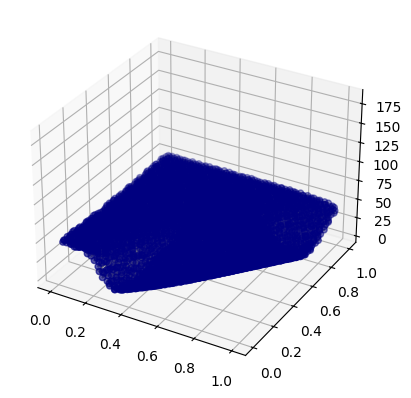

In [58]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
fig = plt.figure('Lorentz')
ax = plt.axes(projection='3d')
ax.plot3D(X['x0'],X['x1'],Y,'gray')
ax.scatter(X['x0'],X['x1'],Y,color=[0,0,0.5],marker='o')

In [61]:
np.max(-Y)

-4.173818519271193

In [241]:
T = np.asarray(T)
T.shape


(2, 1024, 1024)

In [ ]:
#Y = np.asarray(Y)
#Y = np.ndarray(Y)
#print("Y shape : ", Y)
mask = Y == -np.inf
#mask1 = Y1 == -np.inf
#mask
#Replacing the -inf values by a real value
Y[mask] = -10e60
#Y1[mask1] = -10e15

#print(mask)
#print(Y == -np.inf)
#Compute an examplary feature set from the convential ELA features of the R-package flacco
ela_distr = calculate_ela_distribution(X, Y)

#ela_local = calculate_ela_local(X, Y, f=objective_func, dim=dim, lower_bound=[0,0],upper_bound=[1,1],minimize=False, ela_local_local_searches_factor=100 )
#ela_meta = calculate_ela_meta(X, Y)
#ic = calculate_information_content(X, Y, seed = 1800000000)


print("Sample 1 ", ela_dist,"\n_________________________________________________________")
print("Sample 2 : ", ela_distr1)

#print(ela_meta)
#print(ic)
# Compute a Local Optima Network (LON). From this network, LON features can be calculated.
"""
nodes, edges = compute_local_optima_network(
    f = objective_func,
    dim=dim,
    lower_bound=[0,0],
    upper_bound=[1,1],
    seed = None,
    stepsize = 8,
    basin_hopping_iteration = 10,
    stopping_threshold = 100,
    precision = 1e-03,
    minimizer_kwargs = None,
)
"""



In [86]:
lon = calculate_lon_features(nodes, edges)
print("Local optima network", lon)

Local optima network {'lon.n_optima': 114, 'lon.neutral_nodes_proportion': 0.0, 'lon.n_funnels': 2, 'lon.global_funnel_strength_norm': None}


In [81]:
compute_local_optima_network?
calculate_lon_features?

Signature:
compute_local_optima_network(
    f: Callable[[List[float]], float],
    dim: int,
    lower_bound: Union[List[float], float],
    upper_bound: Union[List[float], float],
    seed: Optional[int] = None,
    stepsize: int = 2,
    basin_hopping_iteration: int = 100,
    stopping_threshold: int = 1000,
    precision: float = 1e-05,
    minimizer_kwargs: Optional[Dict[str, Any]] = None,
) -> Tuple[pandas.core.frame.DataFrame, pandas.core.frame.DataFrame]
Docstring:
Computation of a Local Optima Network in accordance to [1].
The data is generated by several basin hopping iterations where each individual iteration executes an optimization algorithm of `scipy`.
Nodes which are similar up to certain precision in fitness are consolidated into one and their respective edges are taken into accoutn.

Parameters
----------
f : Callable[[List[float]], float]
    Objective function to be optimized.
dim : int
    Dimensionality of the decision space.
lower_bound : Union[List[float], float]

In [198]:
import csv
rows = zip(X['x0'], X['x1'], Y)
with open('sample-test.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile)#, delimiter=' ',
                            #quotechar='|', quoting=csv.QUOTE_MINIMAL)
    #spamwriter.writerow(["X1","X2","Y"])
    for rows in zip(X['x0'], X['x1'], Y):
        spamwriter.writerow(rows)
    #spamwriter.writerow(['Spam', 'Lovely Spam', 'Wonderful Spam'])

In [200]:
pip install plotly
import plotly.graph_objects as go

import pandas as pd

# Read data from a csv
z_data = pd.read_csv('sample-test.csv')

fig = go.Figure(data=[go.Surface(z=z_data.values)])

fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

SyntaxError: invalid syntax (2650887463.py, line 1)

## MCMC CALIBRATION

In [86]:
from estival.wrappers import pymc as epm

In [87]:
import pymc as pm

### MCMC INITIALISATION

In [88]:
initvals1 = {"contact_rate": 0.9, "recovery_rate": 0.4}
initvals2 = {"contact_rate": 0.1, "recovery_rate": 0.1}
initvals3 = {"contact_rate": 0.5, "recovery_rate": 0.4}
initvals4 = {"contact_rate": 0.9, "recovery_rate": 0.2}
initval_chains = (initvals1, initvals2, initvals3, initvals4)

In [102]:
with pm.Model() as model:
    
    # This is all you need - a single call to use_model
    variables_defp = epm.use_model(bcm_defp)
    #variables_defp?
    print(model.initial_point())

    # The log-posterior value can also be output, but may incur additional overhead
    # Use jacobian=False to get the unwarped value (ie just the 'native' density of the priors
    # without transformation correction factors)
    # pm.Deterministic("logp", model.logp(jacobian=False))
    
    # Now call a sampler using the variables from use_model
    # In this case we use the Differential Evolution Metropolis sampler
    # See the PyMC docs for more details
    idata_DEM = pm.sample(step=[pm.DEMetropolisZ(variables_defp, S = 3,proposal_dist = pm.NormalProposal)], initvals = initval_chains, draws=10000,tune = 1000 ,cores=4,chains=4)
    #print(model.initial_point()["contact_rate_interval__"])

{'contact_rate_interval__': array(0.), 'recovery_rate_interval__': array(0.)}


Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [contact_rate, recovery_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
#model.debug()

In [ ]:
BayesianCompartmentalModel?

In [ ]:
#pm.Model?
#pm.sample?
#from pymc.blocking import DictToArrayBijection, RaveledVars
#epm.use_model?
from pymc.initial_point import make_initial_point_fn
make_initial_point_fn?

In [ ]:
pm.DEMetropolisZ?

In [190]:
with pm.Model() as model:
    
    # This is all you need - a single call to use_model
    variables_defp = epm.use_model(bcm_defp)
    #variables1 = epm.use_model(bcm1)

    # The log-posterior value can also be output, but may incur additional overhead
    # Use jacobian=False to get the unwarped value (ie just the 'native' density of the priors
    # without transformation correction factors)
    # pm.Deterministic("logp", model.logp(jacobian=False))
    
    # Now call a sampler using the variables from use_model
    # In this case we use the Differential Evolution Metropolis sampler
    # See the PyMC docs for more details
    idata_DEM_2 = pm.sample(step=[pm.Metropolis(variables_defp, S = 1,proposal_dist = pm.NormalProposal)], initvals = initvals2, draws=10000,tune = 1000 ,cores=4,chains=4)   

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [contact_rate]
>Metropolis: [recovery_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 47 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Using arviz to examine outputs

In [90]:
import arviz as az

In [ ]:
az.mcse?

In [191]:
print("DEMetropolis Initialisation 1: \n")
print(az.summary(idata_DEM))
print("____________________________________________\n DEMetropolis Initialisation 2:\n")
print(az.summary(idata_DEM_2))

#idata_DEM?

DEMetropolis Initialisation 1: 

                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
contact_rate   0.470  0.153   0.285    0.768      0.040    0.029      16.0   
recovery_rate  0.259  0.237   0.012    0.701      0.098    0.073       9.0   

               ess_tail  r_hat  
contact_rate       50.0   1.17  
recovery_rate      43.0   1.40  
____________________________________________
 DEMetropolis Initialisation 2:

                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
contact_rate   0.396  0.057   0.297    0.498      0.004    0.003     221.0   
recovery_rate  0.111  0.061   0.010    0.217      0.004    0.003     217.0   

               ess_tail  r_hat  
contact_rate      369.0   1.01  
recovery_rate     351.0   1.01  


In [ ]:
#az.summary(idata1)
az.plot_trace?

In [192]:
# Optional - select some subset out of the resulting trace - useful if
# you require additional burn-in
subset = idata_DEM.sel(draw=slice(1000, None), groups="posterior")

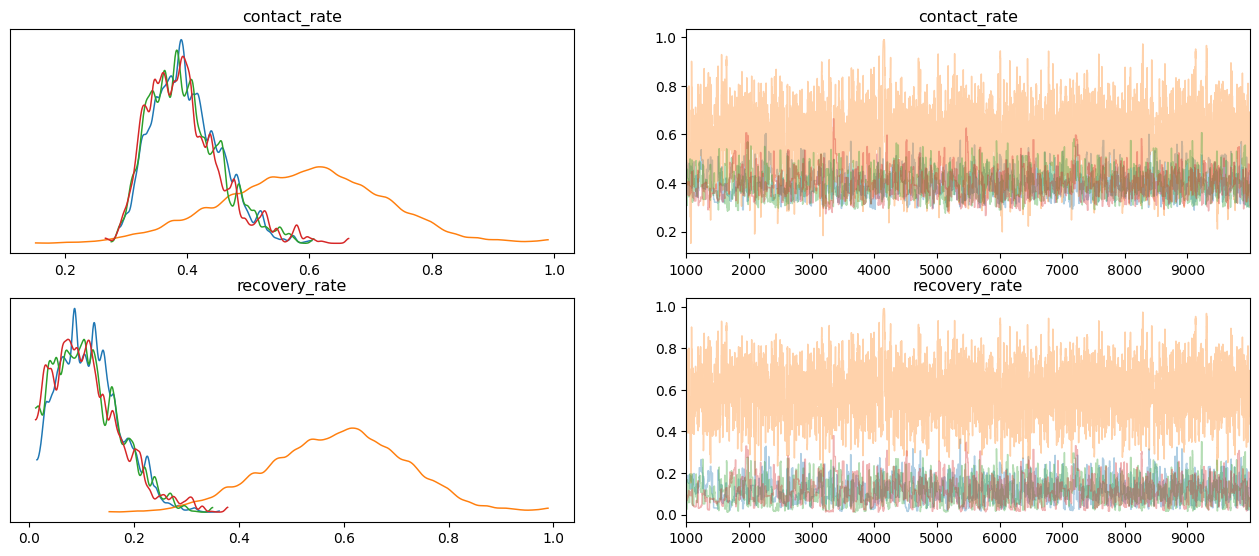

In [193]:
#az.plot_trace(idata, figsize=(16,3.2*len(idata.posterior)),compact=False);#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);
az.plot_trace(subset, figsize=(16,3.2*len(subset.posterior)),compact=False);#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

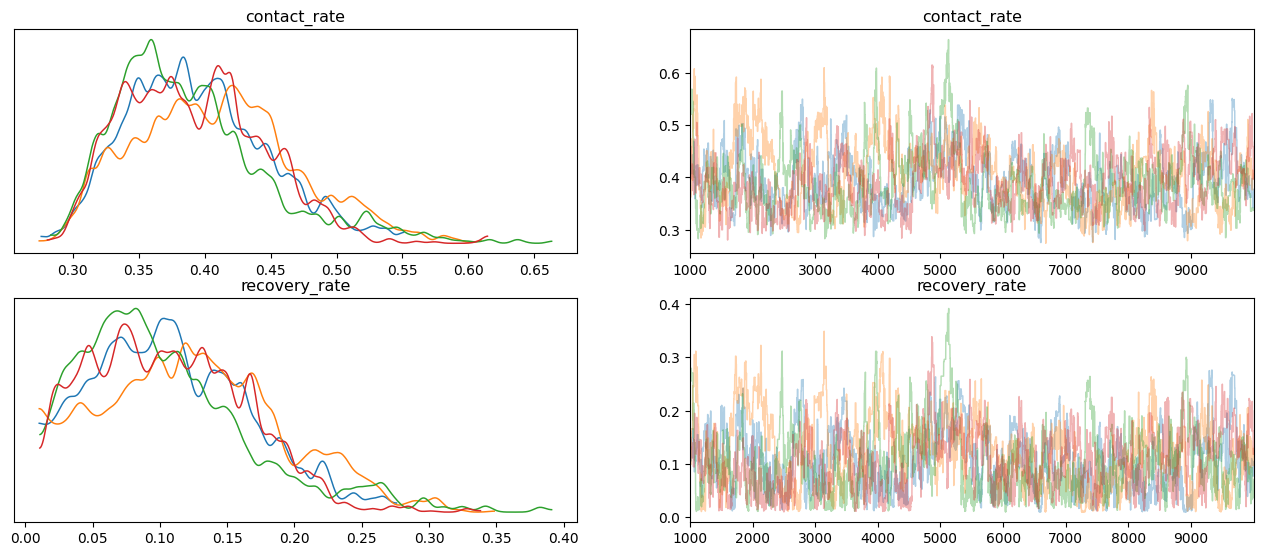

In [194]:
subset = idata_DEM_2.sel(draw=slice(1000, None), groups="posterior")
az.plot_trace(subset, figsize=(16,3.2*len(subset.posterior)),compact=False);#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

### Obtaining likelihood

It is frequently useful to examine the (log)likelihood values of the samples in addition to their distribution

In [108]:
# likelihood_extras_for_idata will compute log likelihood, prior and posterior values,
# as well as invidual likelihood components for each target

from estival.sampling.tools import likelihood_extras_for_idata
from estival.sampling import tools as esamptools

In [109]:
mres = esamptools.model_results_for_samples(idata_DEM_2, bcm_defp)

In [ ]:
resdf = bcm_defp.sample.convert(mres.results, "pandas")
resdf

In [ ]:
resdf["incidence"].keys()
res_chain_0_1 = resdf[]
#resdf["incidence"].index[8]
#mres.results.plot()

In [195]:
likelihood_df = likelihood_extras_for_idata(idata_DEM, bcm_defp)

likelihood_df_2 = likelihood_extras_for_idata(idata_DEM_2, bcm_defp)



IndexError: arrays used as indices must be of integer (or boolean) type

In [220]:
#likelihood_extras_for_idata?

Signature:
likelihood_extras_for_idata(
    idata: arviz.data.inference_data.InferenceData,
    bcm: estival.model.bcm.BayesianCompartmentalModel,
    num_workers: Optional[int] = None,
    exec_mode: str = 'thread',
) -> pandas.core.frame.DataFrame
Docstring:
Calculate the likelihood extras (ll,lprior,lpost + per-target) for all
samples in supplied InferenceData, returning a DataFrame.

Note - input InferenceData must be the full (unburnt) idata

Args:
    idata: The InferenceData to sample
    bcm: The BayesianCompartmentalModel (must be the same BCM used to generate idata)
    num_workers: Number of multiprocessing workers to use; defaults to cpu_count/2

Returns:
    A DataFrame with index (chain, draw) and columns being the keys in ResultsData.extras
        - Use df.reset_index(level="chain").pivot(columns="chain") to move chain into column multiindex
File:      c:\users\abdou\anaconda3\envs\emulearn\lib\site-packages\estival\sampling\tools.py
Type:      function

<Axes: xlabel='draw'>

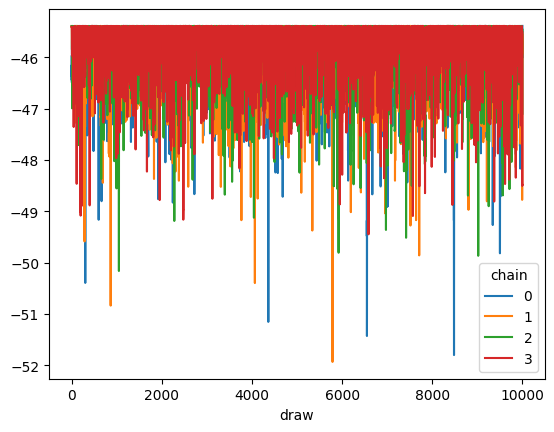

In [112]:
# Examine the performance of chains over time

ldf_pivot = likelihood_df.reset_index(level="chain").pivot(columns=["chain"])

ldf_pivot["logposterior"].plot()

In [ ]:
likelihood_df?

In [114]:
# Sort this DataFrame by logposterior to obtain the MAP index
ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)
ldf_sorted_2 = likelihood_df.sort_values(by="logposterior",ascending=False)

# Extract the parameters from the calibration samples
map_params = idata_DEM_2.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()

para = np.asarray(map_params)
print(map_params)
print(bcm_defp.loglikelihood(**map_params))
#bcm_defp.loglikelihood?

{'contact_rate': 0.6024078242254656, 'recovery_rate': 0.6024078242254656}
-45.97313047554748


In [115]:
# As you can see, this is exactly the value output from the original BCM
bcm_defp.loglikelihood(**map_params), ldf_sorted.iloc[0]["loglikelihood"]

(Array(-45.97313048, dtype=float64), -45.97313047554748)

In [116]:
# Run the model with these parameters
map_res = bcm_defp.run(map_params)

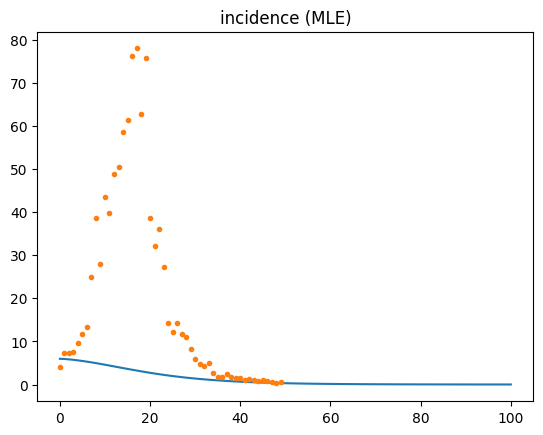

In [117]:
# ...and plot some results
variable = "incidence"

pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
bcm_defp.targets[variable].data.plot(style='.');

#### Uncertainty sampling

In [133]:
# Use the arviz extract method to obtain some samples, then convert to a DataFrame
sample_idata = az.extract(idata_DEM_2, num_samples=4000)# combined = False)#, num_samples = 8000)
print(sample_idata.to_dataframe())
samples_df = sample_idata.to_dataframe().drop(columns=["chain","draw"])
#samples_df
az.extract                                                                                    

            contact_rate  recovery_rate  chain  draw
chain draw                                          
2     2421      0.626671       0.626671      2  2421
1     2576      0.579557       0.579557      1  2576
2     6123      0.532723       0.532723      2  6123
1     1368      0.517518       0.517518      1  1368
3     1795      0.571460       0.571460      3  1795
...                  ...            ...    ...   ...
      511       0.624989       0.624989      3   511
0     9531      0.823906       0.823906      0  9531
3     3415      0.657222       0.657222      3  3415
      4881      0.823084       0.823084      3  4881
      3427      0.699959       0.699959      3  3427

[4000 rows x 4 columns]


<function arviz.data.utils.extract(data, group='posterior', combined=True, var_names=None, filter_vars=None, num_samples=None, keep_dataset=False, rng=None)>

In [134]:
# We use estivals parallel tools to run the model evaluations

from estival.utils.parallel import map_parallel

In [135]:
# Wrapper function captures our bcm from the main namespace to pass into map_parallel
# Using this idiom in closures/factory functions is typical
def run_sample(idx_sample):
    idx, params = idx_sample
    return idx, bcm_defp.run(params)

In [136]:
# Run the samples through our BCM using the above function
# map_parallel takes a function and an iterable as input

# We use 4 workers here, default is cpu_count/2 (assumes hyperthreading)
sample_res = map_parallel(run_sample, samples_df.iterrows(), n_workers=4)

In [137]:
# We'll use xarray for this step; aside from computing things very quickly, it's useful
# to persist the run results to netcdf/zarr etc

import xarray as xr

In [138]:
# Build a DataArray out of our results, then assign coords for indexing
xres = xr.DataArray(np.stack([r.derived_outputs for idx, r in sample_res]), 
                    dims=["sample","time","variable"])
xres = xres.assign_coords(sample=sample_idata.coords["sample"], 
                          time=map_res.derived_outputs.index, variable=map_res.derived_outputs.columns)

In [139]:
# Set some quantiles to calculate
quantiles = (0.01,0.05,0.25,0.5,0.75,0.80,0.95,0.99)

# Generate a new DataArray containing the quantiles
xquantiles = xres.quantile(quantiles,dim=["sample"])

In [140]:
# Extract these values to a pandas DataFrame for ease of plotting

uncertainty_df = xquantiles.to_dataframe(name="value").reset_index().set_index("time").pivot(columns=("variable","quantile"))["value"]

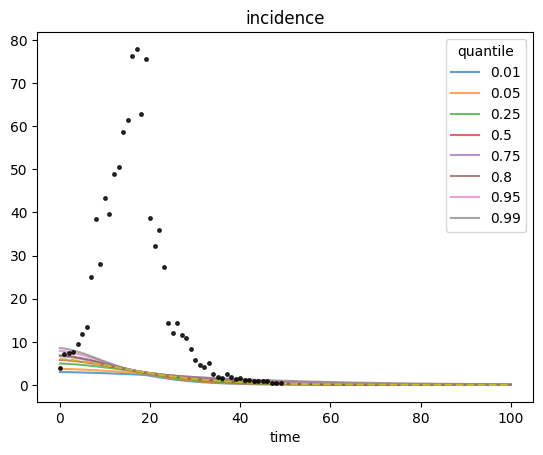

In [141]:
variable = "incidence"

fig = uncertainty_df[variable].plot(title=variable,alpha=0.7)
pd.Series(map_res.derived_outputs[variable]).plot(style='--')
bcm_defp.targets[variable].data.plot(style='.',color="black", ms=5, alpha=0.8);